In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
from fastprogress import progress_bar
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from PIL import Image
from skimage import io, transform
import re
import urllib.request

from preprocess import load, generator
from utils import plot_labelled_image, plot_labelled_sample

Using TensorFlow backend.


In [3]:
images_path = '../data/uploaded_images/'
labels_path = '../data/uploaded_labels.csv'
target_size = 640

In [12]:
all_data = pd.read_json(
    'https://content.mytalkingpet.app/templates?_limit=100&_sort=createdAt:DESC'
)

kp_cols = [
    'uploadedImage',
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]

all_data = all_data[kp_cols]

all_data = all_data.dropna()

def get_floats(string):
    p = re.compile(r'\d+\.\d+|\d+')   
    return p.findall(string)

def split_array(array):
    return float(array[0]), target_size-float(array[1])

for col in kp_cols[1:]:
    all_data[col] = all_data[col].apply(get_floats)
    all_data[col+'_x'], all_data[col+'_y'] = zip(*all_data[col].map(split_array))
    
    all_data = all_data.drop(col, axis=1)

uploadImageDf = pd.DataFrame(all_data['uploadedImage'].values.tolist())
all_data['hash'] = uploadImageDf['hash'].values

In [13]:
for i in progress_bar(range(all_data.shape[0])):
    urllib.request.urlretrieve(
        all_data.iloc[i]['uploadedImage']['url'], 
        "../data/uploaded_images/{}.png".format(all_data.iloc[i]['hash'])
    )

In [14]:
all_data = all_data.drop('uploadedImage', axis=1)

def add_png(hashes):
    return hashes + '.png'

all_data['hash'] = all_data['hash'].apply(add_png)

In [15]:
all_data = all_data[[
    'leftHeadPoint_x', 'leftHeadPoint_y',
    'leftEarPoint_x', 'leftEarPoint_y',
    'topHeadPoint_x', 'topHeadPoint_y',
    'rightEarPoint_x', 'rightEarPoint_y',
    'rightHeadPoint_x', 'rightHeadPoint_y',
    'chinPoint_x', 'chinPoint_y', 
    'leftEyePoint_x', 'leftEyePoint_y',
    'rightEyePoint_x', 'rightEyePoint_y', 
    'leftMouthPoint_x', 'leftMouthPoint_y', 
    'centreMouthPoint_x', 'centreMouthPoint_y',
    'rightMouthPoint_x', 'rightMouthPoint_y', 
    'hash'
]]

all_data.rename(
    columns={
        'leftHeadPoint_x': '0_x', 'leftHeadPoint_y': '0_y',
        'leftEarPoint_x': '1_x', 'leftEarPoint_y': '1_y',
        'topHeadPoint_x': '2_x', 'topHeadPoint_y': '2_y',
        'rightEarPoint_x': '3_x', 'rightEarPoint_y': '3_y',
        'rightHeadPoint_x': '4_x', 'rightHeadPoint_y': '4_y',
        'chinPoint_x': '5_x', 'chinPoint_y': '5_y',
        'leftEyePoint_x': '6_x', 'leftEyePoint_y': '6_y',
        'rightEyePoint_x': '7_x', 'rightEyePoint_y': '7_y',
        'leftMouthPoint_x': '8_x', 'leftMouthPoint_y': '8_y',
        'centreMouthPoint_x': '9_x', 'centreMouthPoint_y': '9_y',
        'rightMouthPoint_x':'10_x', 'rightMouthPoint_y':'10_y',
        'hash': 'filename'
    }, 
    inplace=True
) 

In [16]:
all_data.to_csv(labels_path, index=False)

In [17]:
X, y = load(images_path, labels_path, target_size)

In [19]:
# filename = '0ea9acd5d49445fdbcfda219e5cb07a0.png'

# fig, ax = plt.subplots()
# ax.imshow(np.array(Image.open(images_path+filename)))
# ax.scatter(y.loc[filename][0::2], y.loc[filename][1::2])

# xs = y.loc[filename][0::2]
# ys = y.loc[filename][1::2]
# cols = [
#     'leftHeadPoint', 
#     'leftEarPoint',
#     'topHeadPoint',
#     'rightEarPoint',
#     'rightHeadPoint',
#     'chinPoint',
#     'leftEyePoint',
#     'rightEyePoint',
#     'leftMouthPoint',
#     'centreMouthPoint',
#     'rightMouthPoint'
# ]
# for i in range(11):
#     ax.annotate(cols[i], (xs[i], ys[i]))

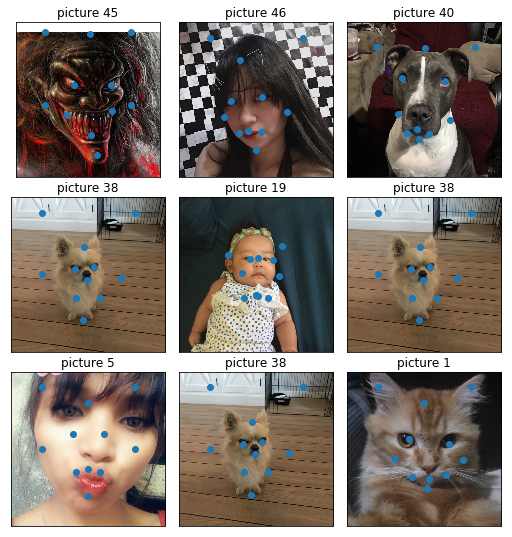

In [20]:
plot_labelled_sample(X, y, target_size, False)